# ALUMNO: Ezequiel Scordamaglia

<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Predicción de próxima palabra

### Objetivo
El objetivo es utilizar documentos / corpus para crear embeddings de palabras basado en ese contexto utilizando la layer Embedding de Keras. Se utilizará esos embeddings junto con layers LSTM para predeccir la próxima posible palabra.

In [1]:
import random
import io
import pickle

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout, SimpleRNN, GRU
from keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from keras.preprocessing.text import text_to_word_sequence # equivalente a word_tokenize de nltk
from keras.utils import pad_sequences # se utilizará para padding


### Datos
Utilizaremos como dataset sentencias tomadas del repositorio https://wortschatz.uni-leipzig.de/en/download/Spanish, pertenecientes a Argentina del año 2019. Se utiliza el modelo de 10K

In [2]:
# Importar sentencias del archivo de texto, separados por tabulacion: data/spa-ar_web-public_2019_300K-sentences.txt
df = pd.read_csv('data/spa-ar_web-public_2019_30K-sentences.txt', sep='\t', header=None, encoding='utf-8')

In [3]:
df.head()

,0,1
0,18,A aquéllas que no concretaron proyectos de más...
1,19,A aquellos involucrados en procesos participat...
2,20,A Argentina la entre todos.
3,21,Abal Medina remarcó sentirse orgulloso de form...
4,22,Abandoné el GP mas bien que hacer la autocriti...


In [4]:
# Unificar los tres corpus, quedandome solo con la columna text
df = df[[1]]


In [5]:
df.head(20)

,1
0,A aquéllas que no concretaron proyectos de más...
1,A aquellos involucrados en procesos participat...
2,A Argentina la entre todos.
3,Abal Medina remarcó sentirse orgulloso de form...
4,Abandoné el GP mas bien que hacer la autocriti...
5,Abarca la investigación de la demanda y de la ...
6,Abastecía de yerba y tabaco a toda la región y...
7,“ABB Argentina ya era reconocida por sus clien...
8,Abdomen mitad del largo.
9,A: Becas para extranjeros para estudios de Doc...


In [6]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 27467


### 1 - Preprocesamiento
- Hay que transformar las oraciones en tokens.
- Dichas oraciones hay que ajustarlas al tamaño fijo de nuestra sentencia de entrada al modelo.
- Hay que separar las palabras objetivos (target) que el modelo debe predecir en cada sentencia armada.

In [7]:

# largo de la secuencia, incluye seq input + word output
train_len = 6
separator_word = 'sep0000'


Debemos transformar ese dataset de filas de oraciones en un texto completo continuo para poder extraer el vocabulario.

In [8]:
# Vistazo a las primeras filas
df.loc[:15]

,1
0,A aquéllas que no concretaron proyectos de más...
1,A aquellos involucrados en procesos participat...
2,A Argentina la entre todos.
3,Abal Medina remarcó sentirse orgulloso de form...
4,Abandoné el GP mas bien que hacer la autocriti...
5,Abarca la investigación de la demanda y de la ...
6,Abastecía de yerba y tabaco a toda la región y...
7,“ABB Argentina ya era reconocida por sus clien...
8,Abdomen mitad del largo.
9,A: Becas para extranjeros para estudios de Doc...


In [9]:
#dejar solo los primeros 12000 registros
df = df.loc[:12000]

In [10]:
# Concatenamos todos los rows en un solo valor
corpus = df[1].str.cat(sep=' ' + separator_word + ' ')
# corpus

In [11]:
# Transformar el corpus a tokens
tokens=text_to_word_sequence(corpus)
# Vistazo general de los primeros tokens
tokens[:29]

['a',
 'aquéllas',
 'que',
 'no',
 'concretaron',
 'proyectos',
 'de',
 'más',
 'largo',
 'alcance',
 'les',
 'quedaban',
 'dos',
 'caminos',
 'por',
 'tomar',
 'desaparecer',
 'o',
 'desenvestir',
 'su',
 'sentido',
 'sep0000',
 'a',
 'aquellos',
 'involucrados',
 'en',
 'procesos',
 'participativos',
 'vinculados']

In [12]:
print("Cantidad de tokens en el corpus:", len(tokens))

Cantidad de tokens en el corpus: 295109


In [13]:
# Código para hacer el desfasaje de las palabras
# según el train_len
text_sequences = []
for i in range(train_len, len(tokens)):
    seq = tokens[i-train_len:i]
    # Si la palabra 'sep0000' está en la secuencia, no la agrego
    if separator_word not in seq:
      text_sequences.append(seq)


In [14]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences[:29]

[['a', 'aquéllas', 'que', 'no'],
 ['aquéllas', 'que', 'no', 'concretaron'],
 ['que', 'no', 'concretaron', 'proyectos'],
 ['no', 'concretaron', 'proyectos', 'de'],
 ['concretaron', 'proyectos', 'de', 'más'],
 ['proyectos', 'de', 'más', 'largo'],
 ['de', 'más', 'largo', 'alcance'],
 ['más', 'largo', 'alcance', 'les'],
 ['largo', 'alcance', 'les', 'quedaban'],
 ['alcance', 'les', 'quedaban', 'dos'],
 ['les', 'quedaban', 'dos', 'caminos'],
 ['quedaban', 'dos', 'caminos', 'por'],
 ['dos', 'caminos', 'por', 'tomar'],
 ['caminos', 'por', 'tomar', 'desaparecer'],
 ['por', 'tomar', 'desaparecer', 'o'],
 ['tomar', 'desaparecer', 'o', 'desenvestir'],
 ['desaparecer', 'o', 'desenvestir', 'su'],
 ['o', 'desenvestir', 'su', 'sentido'],
 ['a', 'aquellos', 'involucrados', 'en'],
 ['aquellos', 'involucrados', 'en', 'procesos'],
 ['involucrados', 'en', 'procesos', 'participativos'],
 ['en', 'procesos', 'participativos', 'vinculados'],
 ['procesos', 'participativos', 'vinculados', 'con'],
 ['participativ

In [15]:
# Proceso de tokenización
tok = Tokenizer() 
tok.fit_on_texts(text_sequences) 

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

# Damos un vistazo
sequences[:20]

[[7, 12242, 6, 20],
 [12242, 6, 20, 13554],
 [6, 20, 13554, 323],
 [20, 13554, 323, 1],
 [13554, 323, 1, 23],
 [323, 1, 23, 267],
 [1, 23, 267, 1825],
 [23, 267, 1825, 228],
 [267, 1825, 228, 3968],
 [1825, 228, 3968, 38],
 [228, 3968, 38, 2553],
 [3968, 38, 2553, 15],
 [38, 2553, 15, 917],
 [2553, 15, 917, 3969],
 [15, 917, 3969, 24],
 [917, 3969, 24, 28638],
 [3969, 24, 28638, 19],
 [24, 28638, 19, 133],
 [7, 661, 3970, 4],
 [661, 3970, 4, 717]]

In [16]:
print("Cantidad de rows del dataset:", len(sequences))

Cantidad de rows del dataset: 247107


### 3 - Input y target

In [17]:
arr_sequences = np.array(sequences)
x_data = arr_sequences[:,:-1]
y_data_int = arr_sequences[:,-1] # aún falta el oneHotEncoder

print(x_data.shape)
print(y_data_int.shape)

(247107, 3)
(247107,)


In [18]:
# Palabras del vocabulario
tok.index_word

{1: 'de',
 2: 'la',
 3: 'el',
 4: 'en',
 5: 'y',
 6: 'que',
 7: 'a',
 8: 'los',
 9: 'del',
 10: 'se',
 11: 'las',
 12: 'con',
 13: 'un',
 14: 'para',
 15: 'por',
 16: 'una',
 17: 'es',
 18: 'al',
 19: 'su',
 20: 'no',
 21: 'como',
 22: 'lo',
 23: 'más',
 24: 'o',
 25: 'este',
 26: 'sus',
 27: 'sobre',
 28: 'esta',
 29: 'fue',
 30: 'entre',
 31: 'desde',
 32: 'también',
 33: 'nacional',
 34: 'ser',
 35: 'año',
 36: 'años',
 37: 'donde',
 38: 'dos',
 39: 'está',
 40: 'todo',
 41: 'pero',
 42: 'trabajo',
 43: 'argentina',
 44: 'hasta',
 45: 'ya',
 46: 'son',
 47: 'todos',
 48: 'cada',
 49: 'le',
 50: 'cuando',
 51: 'tiene',
 52: 'sin',
 53: 'e',
 54: 'ha',
 55: 'nos',
 56: 'ciudad',
 57: 'puede',
 58: 'caso',
 59: 'parte',
 60: 'si',
 61: 'gobierno',
 62: 'provincia',
 63: 'durante',
 64: 'muy',
 65: 'mismo',
 66: 'día',
 67: '1',
 68: '2',
 69: 'lugar',
 70: 'uno',
 71: 'cuenta',
 72: 'tiempo',
 73: 'vez',
 74: 'buenos',
 75: 'personas',
 76: 'desarrollo',
 77: 'hay',
 78: 'así',
 79: 'a

In [19]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

33922

In [20]:
# Transformar los datos a oneHotEncoding
# y_data = to_categorical(y_data_int, num_classes=vocab_size)

In [21]:
# En el caso anterior explota porque y_data_int comienza en "1" en vez de "0"
# valor minimo:
min(y_data_int)

1

In [22]:
y_data_int_offset = y_data_int - 1
y_data = to_categorical(y_data_int_offset, num_classes=vocab_size) 
y_data.shape

(247107, 33922)

### 4 - Entrenar el modelo

In [23]:
# largo de la secuencia de entrada
input_seq_len = x_data.shape[1] 
input_seq_len

3

In [24]:
# Largo del vector de salida --> vocab_size
output_size = vocab_size
output_size

33922

In [25]:
# # Si existe modelo previo, cargarlo. Buscar en path ./models/modelo_spa_10K
# import os

# if os.path.isfile('./models/modelo_spa_10K/saved_model.pb'):
#    model = tf.keras.models.load_model('./models/modelo_spa_10K')

# if os.path.isfile('./models/tokenizer_spa_10K.pkl'):
#    tok = pickle.load(open('./models/tokenizer_spa_10K.pkl', 'rb'))


In [26]:
model = Sequential()

# Embedding:
# input_seq_len = 3 --> ingreso 3 palabras
# input_dim = vocab_size --> 15002 palabras distintas
# output_dim = 5 --> crear embeddings de tamaño 3 (tamaño variable y ajustable)
model.add(Embedding(input_dim=vocab_size+1, output_dim=15, input_length=input_seq_len))

# model.add(LSTM(128, return_sequences=True))
# model.add(Dropout(0.3))
model.add(LSTM(256)) # La última capa LSTM no lleva return_sequences
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))

# Predicción de clasificación con softmax
# La salida vuelve al espacio de 15002 palabras posibles
model.add(Dense(vocab_size, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 3, 15)             508845    
                                                                 
 lstm (LSTM)                 (None, 256)               278528    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 256)               65792     
                                                                 
 dense_1 (Dense)             (None, 33922)             8717954   
                                                                 
Total params: 9571119 (36.51 MB)
Trainable params: 9571119 (36.51 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [27]:
hist = model.fit(x_data, y_data, epochs=10, validation_split=0.2, use_multiprocessing=True)

Epoch 1/10
6178/6178 [==============================] - 667s 107ms/step - loss: 7.3491 - accuracy: 0.0966 - val_loss: 7.1618 - val_accuracy: 0.1098
Epoch 2/10
6178/6178 [==============================] - 617s 100ms/step - loss: 6.7314 - accuracy: 0.1220 - val_loss: 7.2042 - val_accuracy: 0.1168
Epoch 3/10
6178/6178 [==============================] - 609s 98ms/step - loss: 6.3557 - accuracy: 0.1357 - val_loss: 7.2341 - val_accuracy: 0.1246
Epoch 4/10
6178/6178 [==============================] - 623s 101ms/step - loss: 6.0722 - accuracy: 0.1501 - val_loss: 7.2979 - val_accuracy: 0.1294
Epoch 5/10
6178/6178 [==============================] - 614s 99ms/step - loss: 5.8158 - accuracy: 0.1629 - val_loss: 7.3959 - val_accuracy: 0.1301
Epoch 6/10
6178/6178 [==============================] - 599s 97ms/step - loss: 5.5756 - accuracy: 0.1748 - val_loss: 7.5051 - val_accuracy: 0.1334
Epoch 7/10
6178/6178 [==============================] - 591s 96ms/step - loss: 5.3369 - accuracy: 0.1861 - val_loss

d:\Coqui\UBA\Especializacion en Inteligencia Artificial\Procesamiento del Lenguaje Natural\procesamiento_lenguaje_natural (MIO)\venv_PLN\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Coqui\UBA\Especializacion en Inteligencia Artificial\Procesamiento del Lenguaje Natural\procesamiento_lenguaje_natural (MIO)\venv_PLN\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Coqui\UBA\Especializacion en Inteligencia Artificial\Procesamiento del Lenguaje Natural\procesamiento_lenguaje_natural (MIO)\venv_PLN\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future v

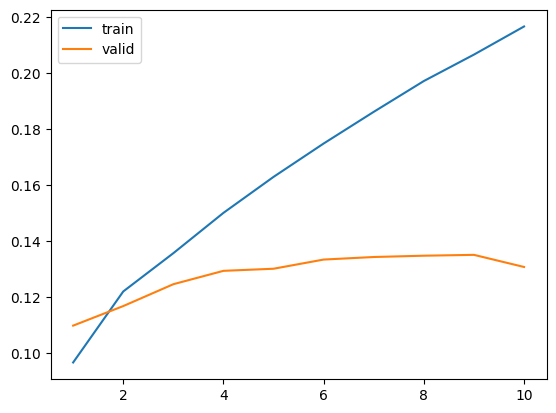

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

In [29]:
# Guardar modelo entrenado en pkl
model.save('./models/modelo_spa_12K',save_format='tf')

INFO:tensorflow:Assets written to: ./models/modelo_spa_12K\assets


INFO:tensorflow:Assets written to: ./models/modelo_spa_12K\assets


In [30]:
# Guardar el tokenizer
with open('./models/tokenizer_spa_12K.pkl', 'wb') as f:
    pickle.dump(tok, f)


### 5 - Predicción de próxima palabra

In [ ]:
# Keras pad_sequences
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
# Si la secuencia de entrada supera al input_seq_len (3) se trunca
# Si la secuencia es más corta se agregna ceros al comienzo

In [28]:
# Se utilizará gradio para ensayar el modelo
# Herramienta poderosa para crear interfaces rápidas para ensayar modelos
# https://gradio.app/
# import sys
# !{sys.executable} -m pip install gradio --quiet

In [58]:
import gradio as gr

def model_response(human_text):

    print("Input: " + human_text)

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=3, padding='pre')
    
    # Predicción softmax
    y_hat = model.predict(encoded).argmax(axis=-1)

    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha

    print("Respuesta: " + human_text + ' ' + out_word)

    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text",
    layout="vertical")

iface.launch(debug=True)

C:\Users\EZEQUIEL\AppData\Local\Temp\ipykernel_18592\468237840.py:29: GradioDeprecationWarning: `layout` parameter is deprecated, and it has no effect
  iface = gr.Interface(


Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


Input: si tengo
1/1 [==============================] - 0s 23ms/step
Respuesta: si tengo de
Input: si tengo dinero
1/1 [==============================] - 0s 22ms/step
Respuesta: si tengo dinero 
Input: siempre hay que
1/1 [==============================] - 0s 22ms/step
Respuesta: siempre hay que del
Keyboard interruption in main thread... closing server.


## CONCLUSIONES

Se realizó un primer entrenamiento del modelo basado en libros de Borges y sin realizar cambios en la arquitectura, pero se observa un overfitting importante en el entrenamiento y los resultados no son buenos.

Se prueba el modelo con los siguientes ejemplos:

```python
Input: un dia soleado
1/1 [==============================] - 0s 21ms/step
Respuesta: un dia soleado yo
Input: yo estaba caminando
1/1 [==============================] - 0s 23ms/step
Respuesta: yo estaba caminando y
Input: yo pase por
1/1 [==============================] - 0s 22ms/step
Respuesta: yo pase por a <------------------------------------(ESTE RESULTADO NO TIENE SENTIDO)
Input: vi que alguien
1/1 [==============================] - 0s 21ms/step
Respuesta: vi que alguien lo
Input: estaba yenedo un
1/1 [==============================] - 0s 23ms/step
Respuesta: estaba yenedo un yo <------------------------------------(ESTE RESULTADO NO TIENE SENTIDO)
Input: queria leer una
1/1 [==============================] - 0s 21ms/step
Respuesta: queria leer una vez 
Input: un hombre iba
1/1 [==============================] - 0s 22ms/step
Respuesta: un hombre iba <------------------------------------(PARA ESTE TEXTO NO HAY NINGUN TOKEN ENCONTRADO)
Input: un hombre paseaba
1/1 [==============================] - 0s 22ms/step
Respuesta: un hombre paseaba <------------------------------------(PARA ESTE TEXTO NO HAY NINGUN TOKEN ENCONTRADO)
Input: un hombre estaba
1/1 [==============================] - 0s 21ms/step
Respuesta: un hombre estaba por
Input: un hombre llegó a
1/1 [==============================] - 0s 20ms/step
Respuesta: un hombre llegó a de  <------------------------------------(ESTE RESULTADO NO TIENE SENTIDO)
```


### 6 - Generación de secuencias nuevas

In [31]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = tokenizer.texts_to_sequences([output_text])[0]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')
		
		# Predicción softmax
        y_hat = model.predict(encoded).argmax(axis=-1)
		# Vamos concatenando las predicciones
        out_word = ''

        # Debemos buscar en el vocabulario la palabra
        # que corresopnde al indice (y_hat) predicho por le modelo
        for word, index in tokenizer.word_index.items():
            if index == y_hat:
                out_word = word
                break

		# Agrego las palabras a la frase predicha
        output_text += ' ' + out_word
    return output_text

In [32]:
input_text='una persona me'

generate_seq(model, tok, input_text, max_length=3, n_words=5)

1/1 [==============================] - 0s 22ms/step


'una persona me esta que del universidad también'

### 7 - Beam search y muestreo aleatorio

In [33]:
# funcionalidades para hacer encoding y decoding

def encode(text,max_length=3):

    encoded = tok.texts_to_sequences([text])[0]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return tok.sequences_to_texts([seq])

In [34]:
from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp=1):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  if (temp == 1):
    idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  else:
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input, temp=1):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = np.squeeze(model.predict(encoded))

    # get vocabulary size
    vocab_size = y_hat.shape[0] 

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens,
                                        temp) 

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = np.squeeze(model.predict(input_update)) 

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens,
                                                        temp) 

    return history_tokens

In [55]:
# predicción con beam search
salidas = beam_search(model,num_beams=10,num_words=5,input="para todo tipo de",temp=2)

1/1 [==============================] - 0s 21ms/step


In [56]:
# veamos las salidas
for salida in salidas:
  print(decode(salida))


['todo tipo de permite estado ellas controles portadores']
['todo tipo de permite 27 cantidad verifique']
['todo tipo de permite 27 cantidad mongolia']
['todo tipo de permite 27 cantidad abigail']
['todo tipo de permite 27 cantidad saludó']
['todo tipo de permite 27 cantidad operativo']
['todo tipo de permite 27 cantidad unos']
['todo tipo de permite 27 cantidad reinstalar']
['todo tipo de permite 27 cantidad “aumentó']
['todo tipo de permite 27 cantidad sancionado']


### 8 - Conclusiones
El modelo entrenado tuvo un muy mail desempeño en el entrenamiento además de overfitting. Cuestiones que podrían mejorarse:
- Agregar más capas o neuronaes
- Incrementar la cantidad de épocas
- Agregar BRNN

Es importante destacar que en este ejemplo estamos entrenando nuestro propios Embeddings, y para ello se requiere mucha data. En los ejemplos que realizaremos de aquí en más utilizaremos más datos, embeddings pre-enternados o modelos pre-entrenados.